In [2]:
# Importing librarys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,make_scorer, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import precision_recall_fscore_support

In [11]:
# Load the titanic dataset
titanic = sns.load_dataset('titanic')
df = pd.DataFrame(titanic)
print(f'Shape of the data : {df.shape}')
df.head()

Shape of the data : (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [12]:
# Pre-processing
# Remove additional columns
columns_to_drop = ['deck','adult_male','fare','alive']
df = df.drop(columns_to_drop, axis=1)

In [13]:
# Fill missing values with the mean
df['age'].fillna(df['age'].mean(), inplace=True)
df['pclass'].fillna(df['pclass'].mean(), inplace=True)

# Fill missing values with a random value
df['sex'].fillna(lambda x: np.random.choice(df['sex'].dropna()), inplace=True)

# Drop rows with missing values
df.dropna()

,survived,pclass,sex,age,sibsp,parch,embarked,class,who,embark_town,alone
0,0,3,male,22.000000,1,0,S,Third,man,Southampton,False
1,1,1,female,38.000000,1,0,C,First,woman,Cherbourg,False
2,1,3,female,26.000000,0,0,S,Third,woman,Southampton,True
3,1,1,female,35.000000,1,0,S,First,woman,Southampton,False
4,0,3,male,35.000000,0,0,S,Third,man,Southampton,True
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,S,Second,man,Southampton,True
887,1,1,female,19.000000,0,0,S,First,woman,Southampton,True
888,0,3,female,29.699118,1,2,S,Third,woman,Southampton,False
889,1,1,male,26.000000,0,0,C,First,man,Cherbourg,True


In [14]:
# Encode categorical variables
encoder = LabelEncoder()
categorical_cols = ['sex','embarked','class','who','embark_town','alone']
for col in categorical_cols:
  df[col] = encoder.fit_transform(df[col])

# Calculate the Z-scores of each column and Remove rows with outliers
z_scores = stats.zscore(df)
df = df[(z_scores < 3).all(axis=1)]

# Display the data
print(f'Shape of the data : {df.shape}')
df.head()

Shape of the data : (839, 11)


,survived,pclass,sex,age,sibsp,parch,embarked,class,who,embark_town,alone
0,0,3,1,22.0,1,0,2,2,1,2,0
1,1,1,0,38.0,1,0,0,0,2,0,0
2,1,3,0,26.0,0,0,2,2,2,2,1
3,1,1,0,35.0,1,0,2,0,2,2,0
4,0,3,1,35.0,0,0,2,2,1,2,1


In [15]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df.drop("survived", axis=1), df["survived"], test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Print the standardized training data
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print('--------------')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (671, 10)
y_train shape: (671,)
--------------
x_test shape: (168, 10)
y_test shape: (168,)


In [18]:
# Tunning hyperparameters

# Define the decision tree classifier
decision_tree_GS = DecisionTreeClassifier()

# Define the parameter grid to search
param_grid = {
    'max_depth': [2,3,4,5,6,7,8,9,10],
    'min_samples_split': [2,5,7,10,13,15,17,19,20],
    'min_samples_leaf': [2,5,7,10,13,15,17,19,20],
    'criterion': ['gini', 'entropy']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=decision_tree_GS,
    param_grid=param_grid,
    scoring=make_scorer(accuracy_score),
    refit='accuracy',
    cv=5
)

# Fit the grid search object to the training data
grid_search.fit(x_train, y_train)

# Print the best hyperparameters and their corresponding score
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [19]:
# Define the decision tree classifier with the best hyperparameters
dt = DecisionTreeClassifier(max_depth=5, min_samples_split=2,min_samples_leaf= 7, criterion='entropy')

# Train the decision tree classifier on the training data
dt.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = dt.predict(x_test)

# Calculate the accuracy, precision, recall, and F1 score on the testing data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Accuracy:  0.7619047619047619
Precision:  0.7777777777777778
Recall:  0.6
F1 Score:  0.6774193548387097


In [20]:
# Visualize the decision tree
col_names = ['pclass','sex','age','sibsp','parch','embarked','class','who','embark_town','alone']
dot_data = export_graphviz(dt, out_file=None, feature_names=col_names,
                           filled=True, rounded=True, class_names=['Not Survived', 'Survived'])
graph = graphviz.Source(dot_data)
graph.render("titanic_decision_tree")

'titanic_decision_tree.pdf'

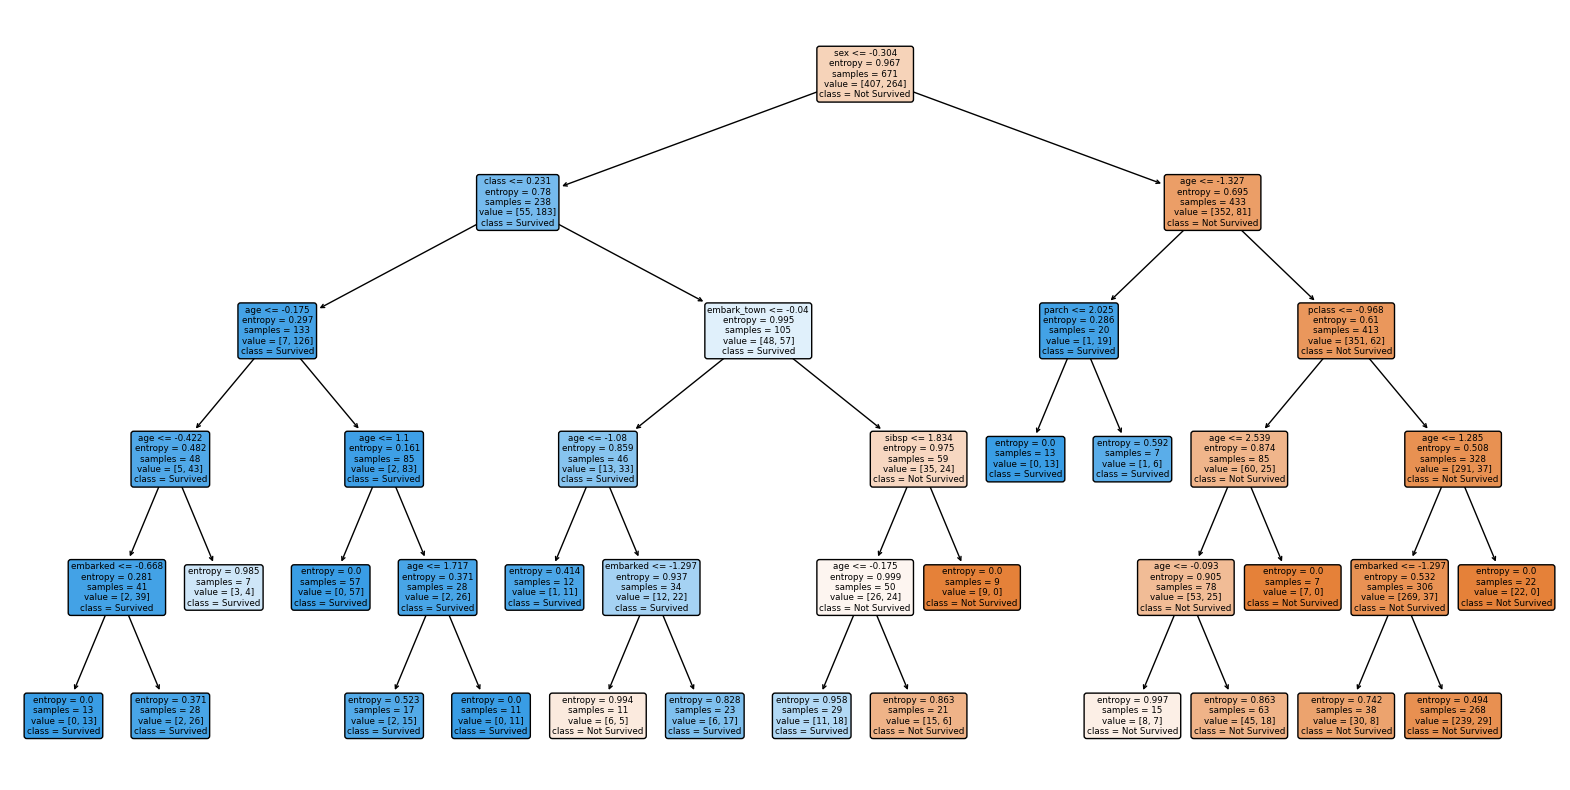

In [21]:
# Alternatively, display the decision tree using Matplotlib
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=col_names, class_names=['Not Survived', 'Survived'], filled=True, rounded=True)
plt.show()

In [22]:
# Create a DecisionTreeClassifier object
dt_p = DecisionTreeClassifier()

# Fit the classifier to the training data
dt_p.fit(x_train, y_train)

# Evaluate the classifier on the testing data
y_pred_p = dt_p.predict(x_test)

# Perform post-pruning on the decision tree
path = dt_p.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas = path.ccp_alphas
dt_ps = []
for ccp_alpha in ccp_alphas:
    dt_p = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    dt_p.fit(x_train, y_train)
    dt_ps.append(dt_p)

# Select the best classifier based on cross-validation score
scores = [dt_p.score(x_test, y_test) for clf in dt_ps]
best_dt_p = dt_ps[scores.index(max(scores))]

# Evaluate the best classifier on the testing data
y_pred_p = best_dt_p.predict(x_test)

In [23]:
# Evaluate the unpruned model
y_pred_unpruned = dt.predict(x_test)
print("Unpruned Decision Tree Performance Metrics:")
print(classification_report(y_test, y_pred_unpruned))

# Evaluate the pruned model
y_pred_pruned = dt_p.predict(x_test)
print("Pruned Decision Tree Performance Metrics:")
print(classification_report(y_test, y_pred_pruned))

Unpruned Decision Tree Performance Metrics:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        98
           1       0.78      0.60      0.68        70

    accuracy                           0.76       168
   macro avg       0.77      0.74      0.74       168
weighted avg       0.76      0.76      0.76       168

Pruned Decision Tree Performance Metrics:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        98
           1       0.00      0.00      0.00        70

    accuracy                           0.58       168
   macro avg       0.29      0.50      0.37       168
weighted avg       0.34      0.58      0.43       168



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Evaluate the unpruned model
accuracy_unpruned= accuracy_score(y_test, y_pred)
precision_unpruned = precision_score(y_test, y_pred)
recall_unpruned = recall_score(y_test, y_pred)
f1_unpruned = f1_score(y_test, y_pred)

# Print the results
print("Unpruned Model Accuracy: ", accuracy_unpruned)
print("Unpruned Model Precision: ", accuracy_unpruned)
print("Unpruned Model Recall: ", recall_unpruned)
print("Unpruned Model F1 Score: ", f1_unpruned)

print("----------------------------")

# Evaluate the pruned model
accuracy_pruned = accuracy_score(y_test, y_pred_p)
precision_pruned = precision_score(y_test, y_pred_p)
recall_pruned = recall_score(y_test, y_pred_p)
f1_pruned = f1_score(y_test, y_pred_p)

# Print the results
print("Pruned Model Accuracy: ", accuracy_pruned)
print("Pruned Model Precision: ", accuracy_pruned)
print("Pruned Model Recall: ", recall_pruned)
print("Pruned Model F1 Score: ", f1_pruned)

Unpruned Model Accuracy:  0.7619047619047619
Unpruned Model Precision:  0.7619047619047619
Unpruned Model Recall:  0.6
Unpruned Model F1 Score:  0.6774193548387097
----------------------------
Pruned Model Accuracy:  0.75
Pruned Model Precision:  0.75
Pruned Model Recall:  0.6428571428571429
Pruned Model F1 Score:  0.6818181818181818


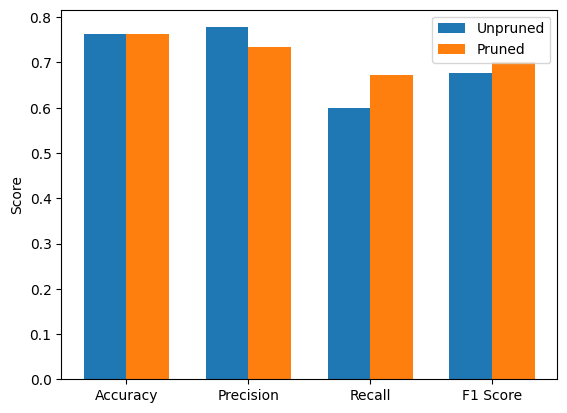

In [ ]:
# Plot the bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
unpruned_scores = [accuracy_unpruned, precision_unpruned, recall_unpruned, f1_unpruned]
pruned_scores = [accuracy_pruned, precision_pruned, recall_pruned, f1_pruned]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, unpruned_scores, width, label='Unpruned')
rects2 = ax.bar(x + width/2, pruned_scores, width, label='Pruned')

ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()